In [49]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Recommended Libraries for Semantic Analysis:
from sentence_transformers import SentenceTransformer
from umap import UMAP
from datasets import load_dataset, DatasetDict, Features, Sequence, Value, load_from_disk


In [50]:
# --- 1. Data Loading and Preprocessing ---
JSONL_FILE_NAME = "datasets/ecommerce_ner_re_dataset.jsonl"

# The sample data provided (replace this with reading your actual JSONL file)
data_examples = load_dataset(
    'json', 
    data_files=JSONL_FILE_NAME, 
    split='train',
)

df = pd.DataFrame(data_examples)

# Extract the primary label (the first relation type) for coloring the plot
# This helps check if texts expressing similar relations cluster together.
def get_primary_relation(relations):
    return relations[0]['type'] if relations else 'NoRelation'

df['primary_relation_type'] = df['relations'].apply(get_primary_relation)
print(f"Loaded {len(df)} documents. Unique relation types: {df['primary_relation_type'].nunique()}")

Loaded 1000 documents. Unique relation types: 1


In [51]:
# --- 2. Embedding Generation (Sentence-Transformers) ---

# Use a pre-trained model optimized for sentence similarity
# 'all-MiniLM-L6-v2' is fast and generally excellent.
print("Generating embeddings with Sentence-Transformer...")
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(df['text'].tolist(), convert_to_numpy=True, show_progress_bar=True)
EMBEDDING_DIM = embeddings.shape[1]
print(f"Embeddings shape: {embeddings.shape}")

Generating embeddings with Sentence-Transformer...


Batches: 100%|██████████| 32/32 [00:09<00:00,  3.47it/s]

Embeddings shape: (1000, 384)


In [52]:
# --- 3. Dimensionality Reduction (UMAP) ---

# UMAP is preferred over PCA/t-SNE as it preserves both local and global structure well.
print("Reducing dimensionality with UMAP...")
reducer = UMAP(
    n_components=2,          # Target dimensions
    n_neighbors=10,          # How many neighbors to consider for local structure
    min_dist=0.1,            # Controls how tightly points are grouped
    metric='cosine',         # Use cosine similarity, standard for SBERT embeddings
    random_state=42
)
reduced_embeddings = reducer.fit_transform(embeddings)

print(reduced_embeddings)
df['UMAP1'] = reduced_embeddings[:, 0]
df['UMAP2'] = reduced_embeddings[:, 1]
print("Dimensionality reduction (UMAP) completed.")

Reducing dimensionality with UMAP...


/home/daniel/projects/git/organizations/data-science-adventure/huggingface-tutorial/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


[[13.138926  -4.8838124]
 [10.269854  18.868572 ]
 [-3.332047  -6.2766814]
 ...
 [14.37718   14.727613 ]
 [ 2.9409103 15.790571 ]
 [14.319194  -5.056774 ]]
Dimensionality reduction (UMAP) completed.


/tmp/ipykernel_18255/1255209864.py:21: MatplotlibDeprecationWarning: You have mixed positional and keyword arguments, some input may be discarded.  This is deprecated since 3.9 and will become an error in 3.11.
  legend1 = plt.legend(


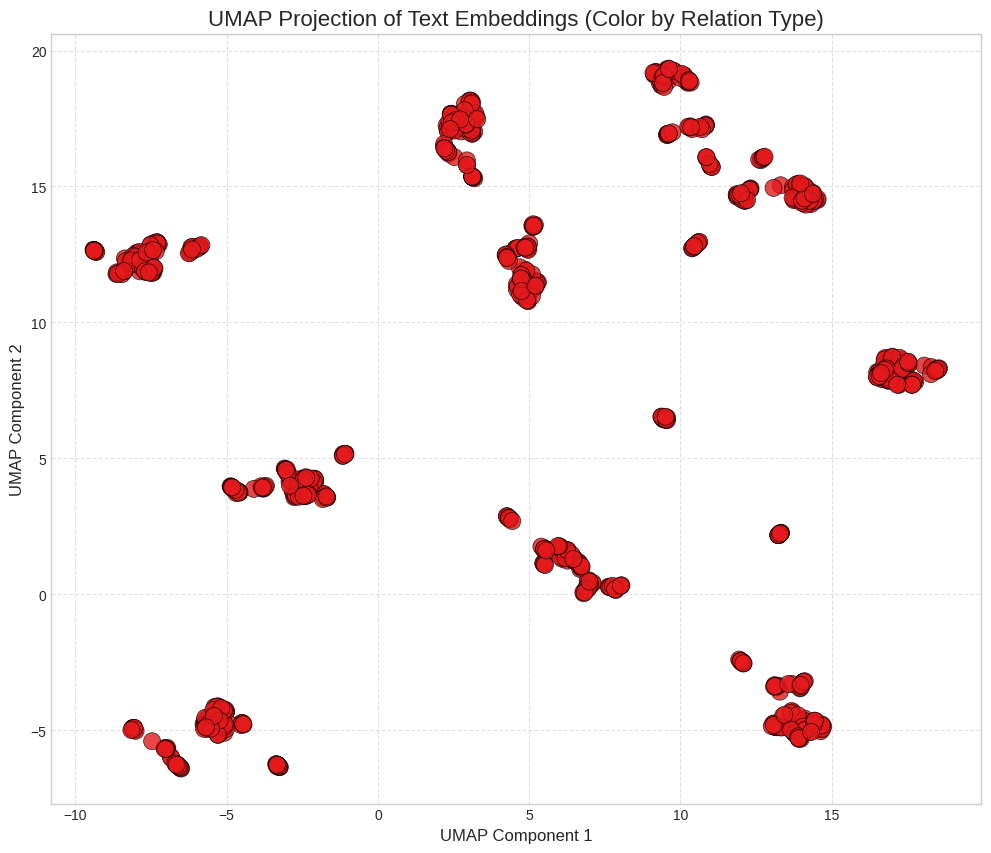


✅ Program finished. Visualization saved to semantic_clustering_umap.png
----------------------------------------
UMAP coordinates for inspection:
    primary_relation_type      UMAP1      UMAP2
0         manufactured_by  13.138926  -4.883812
1         manufactured_by  10.269854  18.868572
2         manufactured_by  -3.332047  -6.276681
3         manufactured_by  -4.501127  -4.723783
4         manufactured_by   2.278207  16.340603
..                    ...        ...        ...
995       manufactured_by   5.566347   1.614992
996       manufactured_by  -7.573922  11.839131
997       manufactured_by  14.377180  14.727613
998       manufactured_by   2.940910  15.790571
999       manufactured_by  14.319194  -5.056774

[1000 rows x 3 columns]


In [53]:
# --- 4. Visualization ---

plt.figure(figsize=(12, 10))
plt.style.use('seaborn-v0_8-whitegrid')

# Scatter plot colored by the extracted primary relation type
scatter = plt.scatter(
    df['UMAP1'],
    df['UMAP2'],
    # Convert string labels to codes for coloring, and use a categorical colormap
    c=df['primary_relation_type'].astype('category').cat.codes, 
    cmap='Set1',
    s=150, 
    alpha=0.8,
    edgecolors='k', 
    linewidth=0.5
)

# Create legend mapping color codes back to relation type names
unique_labels = df['primary_relation_type'].unique()
legend1 = plt.legend(
    *scatter.legend_elements(),
    title="Primary Relation Type",
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    labels=unique_labels
)
plt.gca().add_artist(legend1)

plt.title('UMAP Projection of Text Embeddings (Color by Relation Type)', fontsize=16)
plt.xlabel('UMAP Component 1', fontsize=12)
plt.ylabel('UMAP Component 2', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

plot_filename = "semantic_clustering_umap.png"
plt.savefig(plot_filename, bbox_inches='tight')
plt.show()

print(f"\n✅ Program finished. Visualization saved to {plot_filename}")
print("-" * 40)
print("UMAP coordinates for inspection:")
print(df[['primary_relation_type', 'UMAP1', 'UMAP2']])